# (some) Related Work
- https://www.cambridge.org/core/journals/acta-numerica/article/abs/exponential-integrators/8ED12FD70C2491C4F3FB7A0ACF922FCD (
Hochbruck, M., & Ostermann, A. (2010). Exponential integrators. Acta Numerica, 19, 209-286. doi:10.1017/S0962492910000048)
- Grid-Free Monte Carlo for PDEs with Spatially Varying Coefficients
- Integral formulations of volumetric transmittance 
- On the randomized solution of initial value problems
- A randomised trapezoidal quadrature

# Abstract
We introduce numba for python, the half variance phenomenon and "sensitivity" of random variables in respect to a parameter. Then we finish of by improving the order of RRMC, test a prototype for stabilizing RRMC (DRRMC) and do an example of nonlinear RRMC.

# Intro to Numba
In the next section we will be needing some speedup to run some tests in a reasonable time on our laptop. Python isn't known for speed. We will for now use numba to speed up Python because it requires basically the no amount of effort (for simple code) if you already know Python just some details you have to know. 

## What is Numba
Go see https://numba.pydata.org/. <br>
Numba translates Python functions to optimized machine code at runtime using the industry-standard LLVM compiler library. Numba-compiled numerical algorithms in Python can approach the speeds of C or FORTRAN.

You don't need to replace the Python interpreter, run a separate compilation step, or even have a C/C++ compiler installed. Just apply one of the Numba decorators to your Python function, and Numba does the rest. <br>

## Installation
We installed numba via anaconda (conda install numba). We think you can also install it with pip if you have the correct version of Python.

## Example
Here is a quick example to get your feet wet:

In [45]:
from random import random
from numba import njit, prange

# normal way:
def Y(t): return 1 + (Y(random()*t) if random()<t else 0)
def y(t,nsim): return sum(Y(t) for _ in range(nsim))/nsim

# numba way:
@njit(fastmath=True)
def Yn(t): return 1.0 + (Yn(random()*t) if random()<t else 0.0)

@njit(fastmath=True, parallel=True)
def yn(t, nsim):
    total = 0.0 # <- typing becomes important 0 vs 0.0
    for _ in prange(nsim): # numba likes explicit loops sometimes even over vectorized numpy
        total += Yn(t)
    return total/nsim

In [49]:
t,nsim = 1,10**5
%timeit y(t,nsim)
%timeit yn(t,nsim)

215 ms ± 89.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
5.77 ms ± 295 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In this example numba speeded up the running time 40 times (on our laptop, without counting compile time) with minor changes (typing, decorators, parallel). 

## Disadvantages
Here are some of the main drawbacks of using Numba:

-   Limited support for Python features: Numba supports a limited subset of Python features, which means that not all Python code can be accelerated with Numba. (like classes and we aren't sure that sparse operations are supported)

-   Debugging: Numba can make debugging more difficult. 

-   Adds a dependency 

# Real World Example
The implementation of UMAP uses numba: https://github.com/lmcinnes/umap <br>
"UMAP depends upon scikit-learn, and thus scikit-learn's dependencies such as numpy and scipy. UMAP adds a requirement for numba for performance reasons. The original version used Cython, but the improved code clarity, simplicity and performance of Numba made the transition necessary."

# Half Variance Phenomenon
Ok we need a better name for this. The half variance phenomenon is the order improvement of  randomized integrators over classic integrators ones. The order improvement happens because of instead summing errors you sum variances which after taking the $\sqrt{ }$ end up reducing the order less. See (A randomised trapezoidal quadrature) for an in depth discussion. <br>

To demonstrate the half variance phenomenon we compare the classic trapezium rule vs the MC trapezium rule. In $1$ dimensional integration we gain a cheap half order of convergence, in $d$ dimensional this becomes $\frac{d}{2}$. We aren't sure this will transfer to PDE solvers ...
## 1D MC Trapezium Rule
We russian roulette our function calls such that the MC version only add $1\%$ extra function calls (russian roulette rate $100$). We also estimate the error of the trapezium rule using the standard deviation.

In [112]:
from random import random
from math import exp,sqrt
from numba import njit, prange
from functools import lru_cache
import numpy as np
import matplotlib.pyplot as plt

#@lru_cache(maxsize=4)
@njit
def f(x): return exp(x) 
    
@njit(fastmath=True)
def trapezium(n,a,b):
    dx = (b-a)/n
    x,sol = 0,0
    for _ in range(n):
        xx = x + dx
        sol += (f(x)+f(xx))/2 # inefficient
        x = xx
    return sol*dx

@njit(fastmath=True)
def MCtrapezium(n,a,b):
    dx = (b-a)/n
    x,sol,solMC,solMC2 = 0,0,0,0
    for _ in range(n):
        xx = x + dx
        sol += dx*(f(x)+f(xx))/2 # inefficient
        l = 100 # russian roulette rate 
        if random()*l<1:
            U = x + random()*(xx-x) # \sim Uniform(x,xx)
            tmp= dx*l*(f(U)-f(x)-(U-x)*(f(xx)-f(x))/dx)
            solMC += tmp
            solMC2 += tmp**2/dx
        x = xx
    return sol+solMC, sqrt(solMC2-solMC**2)

def exact(a,b): return exp(b)-exp(a) 

C:\Users\Admin\AppData\Local\Temp\ipykernel_10432\3743616432.py:13: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(DTS)/np.log(10),np.log(MCsig)/np.log(10), label = "MC std")


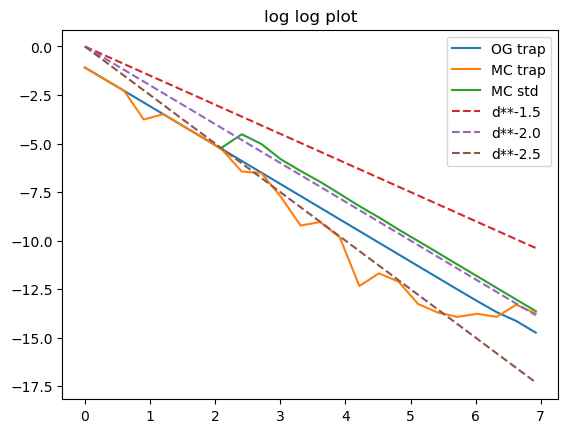

In [126]:
def MCtrap_llplot():
    n,a,b = 100,0,1
    DTS = np.power(2,np.array(range(24)))
    errors = np.array([(abs(trapezium(n,a,b)-exact(a,b)))/(exact(a,b)) for n in DTS])
    MCerrors,MCsig = [],[]
    for n in DTS:
        sol,sig = MCtrapezium(n,a,b)
        MCerrors.append((abs(sol-exact(a,b)))/(exact(a,b)))
        MCsig.append(sig)

    plt.plot(np.log(DTS)/np.log(10),np.log(errors)/np.log(10), label = "OG trap")
    plt.plot(np.log(DTS)/np.log(10),np.log(MCerrors)/np.log(10), label = "MC trap")
    plt.plot(np.log(DTS)/np.log(10),np.log(MCsig)/np.log(10), label = "MC std")
    dgs = np.arange(1.5,3,0.5)
    for l in dgs:
        ref = np.array([pow(1/d,l) for d in DTS])
        plt.plot(np.log(DTS)/np.log(10),np.log(ref)/np.log(10),label =f"d**-{l}",linestyle="dashed")
    plt.legend()
    plt.title("log log plot")
    plt.show()

MCtrap_llplot()

we don't know what goes wrong in the convergence probably numerical precision stuff ... 

## 2D MC Trapezium Rule 

In here we use a russian rate of $10$.

In [5]:
from random import random
from math import exp,sqrt
from numba import njit, prange
from functools import lru_cache
import numpy as np
import matplotlib.pyplot as plt

#@lru_cache(maxsize=4)
@njit
def f2(x,y): return exp(x)*exp(y)

@njit(fastmath=True)
def trapezium2(n):
    d = 1/n
    x,sol = 0,0
    for _ in range(n):
        y = 0
        for _ in range(n):
            sol += ((f2(x+d,y)+f2(x,y+d))/2 )*d**2 # inefficient
            y +=d
        x+=d
    return sol

@njit(fastmath=True)
def MCtrapezium2(n):
    d = 1/n
    x,sol,solMC,solMC2 = 0,0,0,0
    for _ in range(n):
        y = 0
        for _ in range(n):
            sol += ((f2(x+d,y)+f2(x,y+d))/2 )*d**2 # inefficient
            l = 10 # russian roulette rate l>1
            if random()*l<1:
                X,Y = x + d*random(), y + d*random()
                tmp= l*(f2(X,Y)-(f2(x,y)+(f2(x+d,y)-f2(x,y))*(X-x)/d+(f2(x,y+d)-f2(x,y))*(Y-y)/d))*d 
                solMC += tmp*d
                solMC2 += tmp**2
            y +=d
        x+=d
    return sol+solMC, sqrt(solMC2-solMC**2)


def exact2(): return (exp(1)-1)**2


C:\Users\Admin\AppData\Local\Temp\ipykernel_11252\557481967.py:13: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(DTS)/np.log(10),np.log(MCsig)/np.log(10), label = "MC std2")


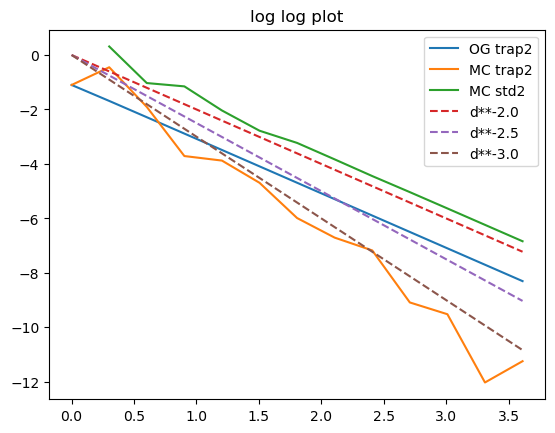

In [7]:
def MCtrap2_llplot():
    DTS = np.power(2,np.array(range(13)))
    errors = np.array([(abs(trapezium2(n)-exact2()))/(exact2()) for n in DTS])

    MCerrors,MCsig = [],[]
    for n in DTS:
        sol,sig = MCtrapezium2(n)
        MCerrors.append((abs(sol-exact2()))/(exact2()))
        MCsig.append(sig)

    plt.plot(np.log(DTS)/np.log(10),np.log(errors)/np.log(10), label = "OG trap2")
    plt.plot(np.log(DTS)/np.log(10),np.log(MCerrors)/np.log(10), label = "MC trap2")
    plt.plot(np.log(DTS)/np.log(10),np.log(MCsig)/np.log(10), label = "MC std2")

    dgs = np.arange(2,3.5,0.5)
    for l in dgs:
        ref = np.array([pow(1/d,l) for d in DTS])
        plt.plot(np.log(DTS)/np.log(10),np.log(ref)/np.log(10),label =f"d**-{l}",linestyle="dashed")

    plt.legend()
    plt.title("log log plot")
    plt.show()

MCtrap2_llplot()

# Sensitivity of Random Variables

We don't know if this has solid footing but we find it intrestring. Say we have a RV that depends on a parameter and we want to know how small variations of that parameter influence that RV (like a derivative). We "define" the sensitivity of a RV with respect to a parameter by rewriting that RV such that the parameter doesn't appear in the random part and then taking the regular derivative of that expression. We haven't proofed that this definition is water tight but think it is a lead to something useful.  

## Examples

Let $U \sim \text{Uniform}(0,1)$. In what follows $U$ will be the same random variable when it pops up in the same expression. 
### Example 1
$$
\partial_{t}(U^{t}) = \ln{(U)} U^{t}.
$$ 
### Example 2
Lets do a RMC example (product rule + chain rule):
$$
\begin{align*}
Y(t)&= 1 + t Y(Ut) \\
\partial_{t}Y(t)&= t U \partial_{t}Y(Ut) + Y(Ut)
\end{align*}
$$ 
we are actually only interested if the expectation of the sensitivity are right. We test this in a implementation:

In [52]:
from random import random
from numba import njit, prange
import numpy as np

@njit(fastmath=True)
def X(t):
    if random()>t: return np.array((1.0,0.0))
    U = random()
    ys,dys = X(U*t)
    yt = 1.0 + ys
    dyt = ys/t + U*dys
    return np.array((yt,dyt))

@njit(fastmath=True, parallel=True)
def x(t, nsim):
    total = np.zeros(2) 
    for _ in prange(nsim):
        total += X(t)
    return total/nsim

In [63]:
print(x(1,10**6))

[2.717896 2.718215]


### Example 3
Another RMC example:
$$
\begin{align*}
Y(t,a)&= 1 + ta Y(Ut,a) \\
\partial_{a}Y(t,a)&= t (Y(Ut,a) + a \partial_{a}Y(Ut,a) )
\end{align*}
$$ 
Remember that $E(t,a) = e^{ta}$. Lets implement this:

In [65]:
from random import random
from math import exp
import numpy as np

def X2(t,a):
    if random()>t: return np.array((1,0)) 
    U = random()
    ys,days = X2(U*t,a) 
    yt = 1 + a*ys*(1 if t<1 else t)
    dayt = (ys + a*days)*(1 if t<1 else t)
    return np.array((yt,dayt))

def test_dRV3():
    t, a, nsim = 1.2, 2, 10**3 
    s = sum(X2(t, a) for _ in range(nsim))/nsim
    sol = np.array([exp(t*a), t*exp(t*a)])
    err = (s-sol)/sol
    print(f"X2 = {s}", f"%error is {err}")

test_dRV3()

X2 = [10.69636672 12.17739628] %error is [-0.0296475  -0.07940961]


### Conclusion
This may be another way to generate sensitivity equation directly from recursive RV definitions.


# Linear RRMC

We add some improvements to RRMC for ODEs by using control variates and simple Green functions. We distinguish between linear and nonlinear because non linear RRMC is biased. 

## Control Variates and RRMC
We use a similar approach to (On the randomized solution of initial value problems) by using polynomial CV (control variate) to increase the order of RRMC to the information optimal order of randomized IVPs:


$$
y'=y,y(0)=1.
$$

this has integral equation:

$$
y(t)= y(T)+ \int_{T}^{t}y(s)ds .
$$

in the inner recursion we have accesses to $y(T)$ from the outer recursion. From this we can calculate an estimate of $y'(T) = y(T)$ and use that to make a linear function as CV:

$$
y(s) \approx y(T) + (s-T) y'(T).
$$

sub this in the integral equation

$$
\begin{align*}
y(t)&= y(T)+ \int_{T}^{t}y(s)ds \\
&= y(T)+ \int_{T}^{t}y(s) - (y(T) + (s-T) y'(T)) +y(T) + (s-T) y'(T)ds \\
\end{align*}
   .
$$

integrating the CV is possible because it is a polynomial:

$$
\begin{align*}
\int_{T}^{t} &y(T) + (s-T) y(T)ds \\
&= y(T)\left((1-T)(t-T) + \frac{t^{2}-T^{2}}{2} \right)
\end{align*}
.
$$

here is the implementation:


In [132]:
from random import random
from math import exp,pow
import matplotlib.pyplot as plt
import numpy as np
from numba import njit, prange

@njit(fastmath=True)
def Y_fast(t, T, yT, DT):
    sol = yT*(1 + (1-T)*(t-T)+ (t**2-T**2)/2)
    l = 10 # russian roulette rate l>1
    if random()*l < (t-T)/DT:
        S = T + random()*(t-T)  #\sim Uniform(T,t)
        sol += l*DT*(Y_fast(S, T, yT, DT) -yT*(1+S-T))
    return sol 

@njit(fastmath=True)
def Y_slow(T, DT: "step size slow recursion"):
    y,t = 1.0,0.0
    while t<T:
        tt = t+DT if t+DT<T else T
        y = Y_fast(tt, t, y, tt-t) 
        t=tt
    return y


@njit(fastmath=True, parallel=True)
def solX(T, DT, nsim ):
    total = 0.0
    for _ in prange(nsim):
        total += Y_slow(T,DT)
    return total/nsim


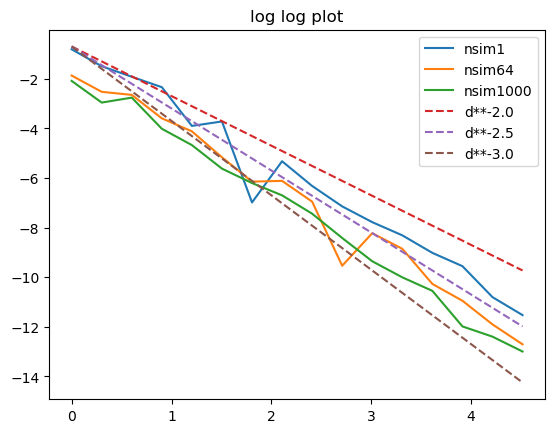

In [134]:
def CVRRMC_llplt():
    T = 2
    DTS = np.power(0.5,np.array(range(16)))
    Ns = [1,64,1000]
    for nsim in Ns:
        errors = np.array([(abs(solX(T, d, nsim )-exp(T)))/(exp(T)) for d in DTS])
        plt.plot(-np.log(DTS)/np.log(10),np.log(errors)/np.log(10), label = f"nsim{nsim}")

    dgs = np.arange(2,3.5,0.5)
    for l in dgs:
        ref = np.array([pow(d,l) for d in DTS])
        plt.plot(-np.log(DTS)/np.log(10),np.log(ref/5)/np.log(10),label =f"d**-{l}",linestyle="dashed")
    plt.legend()
    plt.title("log log plot")
    plt.show()

CVRRMC_llplt()

## DRRMC (Diagonal RRMC)
Our current examples of RMC  ignore stability problems (like stiff problems stuff). What it comes down to is big coefficients in front of recursive terms that gets multiplied multiple times which causes instability that forces you to use smaller time steps when your CVs are just doing fine. <br>  
We don't really like talking about stiff problems but you also have a case where polynomial CVs aren't the right choice like when you have really obvious high frequency terms which also is a stupid reason to use smaller step sizes. <br>

DRRMC tries to avoid big coefficients in front of recursive terms by using an other integral representation like exponential integrators (https://en.wikipedia.org/wiki/Exponential_integrator) or like how $\bar{\sigma}$ gets chosen in (Grid-Free Monte Carlo for PDEs with Spatially Varying Coefficients). 

### Derivation
Lets look at a general linear ODE IVP problem:
$$
X' = AX+g, X(0)= X_{0}.
$$ 
Let $D$ be a constant diagonal matrix
$$
X' + DX = (A+D)X+g.
$$ 
integral representation  of this is
$$
X(t)= e^{D(T-t)}X(T) + \int_{T}^{t} e^{D(s-t)}(A+D)X(s)ds+\int_{T}^{t} e^{D(s-t)}g(s)ds .
$$ 
first you should make sure that the non-recursive integral isn't a bottleneck. Now we want to chose $D$ such that multiple multiplication of $e^{D(s-t)}(A(s)+D)$ won't make things explode.<br>
Analyzing that is annoying because different $s$ give different results. We want some criteria like the geometric average of the biggest eigenvalue must be smaller then $1$. <br> 
We think that increasing $D$ element wise on the diagonal can stabilize results because in the limit $D \rightarrow \infty \Rightarrow s < t:e^{D(s-t)}(A(s)+D) \rightarrow 0 $  but $D \rightarrow \infty \Rightarrow s = t:e^{D(s-t)}(A(s)+D) \rightarrow \infty$. <br>
We haven't yet figured out how to chose $D$ at each outer recursion in general ... our best guesses now is the magnitude of the rows of $A$ or by choosing $D$ such that: 
$$
\left|\left|\tilde{X}(t)-e^{D(T-t)}X(T) -\int_{T}^{t} e^{D(s-t)}g(s)ds \right|\right|
$$ 
is small where $\tilde{X}(t)$ is a guess of $X(t)$ via the same techniques to construct CVs.  




### Example

Lets do an example. Following example comes from (https://en.m.wikipedia.org/wiki/Stiff_equation).

$$
x'= Ax, x= (1 \text{ } 0)^{T}.
$$

with

$$
A = \begin{pmatrix}
0 & 1 \\
-1000 & -1001
\end{pmatrix}.
$$

we choose $D$ fixed over all outer recursions:

$$
D = \begin{pmatrix}
1 & 0 \\
0 & 1000
\end{pmatrix}.
$$

Here is the implementation of this:


In [8]:
from random import random
from math import exp
import numpy as np
from numba import njit, prange


#returns exp(D*x) where D diagonal
@njit(fastmath =True)
def expDiag(D,x): return np.diag(np.exp(np.diag(D*x)))

@njit(fastmath =True)
def X_fast(t, T, xT,  D,A, DT):
    sol = expDiag(D,T-t) @ xT
    if random() < (t-T)/DT:
        S = T + random()*(t-T)  # \sim Uniform(T,t)
        sol += DT*expDiag(D,S-t) @ ((A+D) @ X_fast(S, T, xT, D,A,DT)) 
    return sol 

@njit(fastmath =True)
def X_slow(T, DT: "step size slow recursion"):
    x,t = np.array([1.0,0.0]),0.0
    D = np.array([[1.0,0.0],[0.0,1000.0]])
    A = np.array([[0,1],[-1000,-1001]])
    while t<T:
        tt = t+DT if t+DT<T else T
        x = X_fast(tt, t, x, D, A, tt-t) 
        t=tt
    return x


@njit(fastmath=True, parallel=True)
def solX(T, DT, nsim ):
    total = np.zeros(2)
    for _ in prange(nsim):
        total += X_slow(T,DT)
    return total/nsim

def exactX(t):
    x = -exp(-1000*t)/999 + 1000*exp(-t)/999
    dx = 1000*exp(-1000*t)/999 - 1000*exp(-t)/999
    return np.array([x,dx])


In [310]:
def testX(t):
    DTS = [0.1,0.05,0.01,0.005,0.05]
    nsims = [10**4,10**4,10**3,10**2,1]
    for DT,nsim in zip(DTS,nsims):
        error =(solX(t,DT,nsim)-exactX(t))/exactX(t) 
        print(f"DT, nsim = {DT}, {nsim}, %error = {error}")
testX(1)

DT, nsim = 0.1, 10000, %error = [0.06231436 0.74702381]
DT, nsim = 0.05, 10000, %error = [-0.0192854   0.06317045]
DT, nsim = 0.01, 1000, %error = [-0.0018453  -0.00270515]
DT, nsim = 0.005, 100, %error = [ 0.01148272 -0.06621385]
DT, nsim = 0.05, 1, %error = [ 0.61970439 -1.        ]


Stability doesn't imply accuracy but at the other hand classic methods struggle with these type of problems. The big non-linearity from the exponential makes control variating/important sampling way more important. To CV this we need an integrable approximation of:

$$
e^{D(s-t)}(A(s)+D)X(s)
$$

Linearlizing this isn't great because of that exponential, the way to go is to keep the exponential and linearlizing the rest. We build a linear approximation of the rest by evaluating the rest twice (this way makes it nicer when you have more information in time from an other solver for example) up to first order details and interpolating. Call the rest $q(s) =(A(s)+D)X(s)$.

$$
q(s) \approx q(T) + \frac{s-T}{t-T} (\tilde{q}(t)-q(T)).
$$

where we $\tilde{q}(t)$ is an approximation of $q(t)$:

$$
\tilde{q}(t) \approx (A(t)+D)(X(T)+(t-T)(A(T)X(T)+g(T))).
$$

Because our control variate is basically an exponential times a polynomial it is possible to integrate analytically:

$$
\int_{T}^{t} e^{D(s-t)} \left(q(T) + \frac{s-T}{t-T}(\tilde{q}(t) -q(T))\right) ds
$$

introduce following notation: $DT = t -T$, $\Delta \tilde{q} = \frac{\tilde{q}(t)-q(T)}{DT}$ do following sub in the previous integral: $u = s-T, du = ds$:

$$
\begin{align*}
\int_{T}^{t} &e^{D(s-t)} \left(q(T) + \frac{s-T}{t-T}(\tilde{q}(t) -q(T))\right) ds \\
&= \int_{0}^{DT} e^{D(u-DT)}\left( q(T) + u\Delta\tilde{q} \right)ds \\
&= D^{-1}\left(  I - e^{-D DT}\right) q(T)  \\
    &+ \int_{0}^{DT} e^{D(u-DT)} u\Delta \tilde{q} ds \\
&= D^{-1}\left(  I - e^{-D DT}\right) q(T)  \\
    &+ \left( D^{-1}(DT I - D^{-1}) + D^{-2}e^{-D DT} \right)\Delta \tilde{q}  \\

\end{align*}
.
$$

You could implement this formula with only arrays that represent the diagonal matrix. Here is our implementation:


In [13]:
from random import random
from math import exp
import numpy as np
from numba import njit, prange

# compile time of this code is like 30 sec

#returns exp(D*x) where D diagonal
@njit(fastmath =True)
def expDiag(D,x): return np.diag(np.exp(np.diag(D*x)))

@njit(fastmath =True)
def powDiag(D,deg): return np.diag(np.power(np.diag(D),deg))

@njit(fastmath =True)
def X2_fast(t, T, xT,q,Dtilq,  D,A, DT):
    sol = expDiag(D,T-t) @ xT
    sol += powDiag(D,-1) @ ((np.identity(2)-expDiag(D,-(t-T)))@q)
    #sol += ((t-T)*powDiag(D,-1) - powDiag(D,-2)+(powDiag(D,-2)@expDiag(D,-(t-T))))@Dtilq
    l = 2 # russian roulette rate
    if random()*l < (t-T)/DT:
        S = T + random()*(t-T)  # \sim Uniform(T,t)
        sol += l*DT*expDiag(D,S-t) @ ((A+D) @ X2_fast(S, T, xT,q,Dtilq, D,A,DT)- (q) ) #+ (S-T)*Dtilq 
    return sol 

@njit(fastmath =True)
def X2_slow(T, DT,D):
    x,t = np.array([1.0,0.0]),0.0
    A = np.array([[0.0,1.0],[-1000.0,-1001.0]])
    while t<T:
        tt = t+DT if t+DT<T else T
        tilq = (A+D)@(x+(tt-t)*(A@x))
        q = (A+D)@x
        Dtilq = (tilq-q)/(tt-t) 
        x= X2_fast(tt, t, x,q, Dtilq, D, A, tt-t) 
        t=tt
    return x


@njit(fastmath =True,parallel=True)
def solX2(T, DT, nsim,D ):
    total = np.zeros(2)
    for _ in prange(nsim):
        total += X2_slow(T,DT,D)
    return total/nsim

def exactX(t):
    x = -exp(-1000*t)/999 + 1000*exp(-t)/999
    dx = 1000*exp(-1000*t)/999 - 1000*exp(-t)/999
    return np.array([x,dx])

# compile time of this code is like 30 sec

In [14]:
def testX2(t):
    DTS = [0.5,0.1,0.1,0.05,0.01,0.005]
    nsims = [10**3,10**2,1,1,1,1]
    D = np.array([[1.0,0.0],[0.0,1000.0]])
    for DT,nsim in zip(DTS,nsims):
        error =(solX2(t,DT,nsim,D)-exactX(t))/exactX(t) 
        print(f"DT, nsim = {DT}, {nsim}, %error = {error}")
testX2(1)

DT, nsim = 0.5, 1000, %error = [0.48781367 0.00921415]
DT, nsim = 0.1, 100, %error = [-0.03528596  0.05104099]
DT, nsim = 0.1, 1, %error = [-0.23034038 -0.1410625 ]
DT, nsim = 0.05, 1, %error = [-0.04554106  0.00359378]
DT, nsim = 0.01, 1, %error = [ 0.0077167  -0.01834407]
DT, nsim = 0.005, 1, %error = [0.00423355 0.00830349]


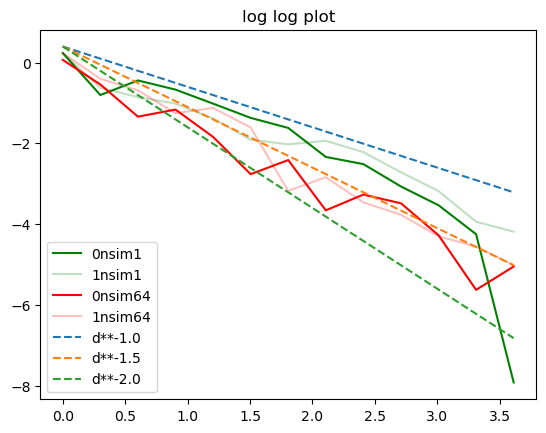

In [23]:
import matplotlib.pyplot as plt
def CVDRRMC_llplt():
    T = 1
    DTS = np.power(0.5,np.array(range(13)))
    D = np.array([[1.0,0.0],[0.0,1000.0]]) # play around with the D 
    Ns = [1,64]
    colors = ["green","red"]
    for nsim,c in zip(Ns,colors):
        errorsX0,errorsX1 = zip(*[np.absolute((solX2(T, d, nsim,D )-exactX(T))/(exactX(T))) for d in DTS])
        errorsX0 = np.array(errorsX0)
        errorsX1 = np.array(errorsX1)
        plt.plot(-np.log(DTS)/np.log(10),np.log(errorsX0)/np.log(10), label = f"0nsim{nsim}",color =c)
        plt.plot(-np.log(DTS)/np.log(10),np.log(errorsX1)/np.log(10), label = f"1nsim{nsim}",alpha = 0.25,color =c)

    dgs = np.arange(1,2.5,0.5)
    for l in dgs:
        ref = np.array([pow(d,l) for d in DTS])
        plt.plot(-np.log(DTS)/np.log(10),np.log(2.5*ref)/np.log(10),label =f"d**-{l}",linestyle="dashed")
    plt.legend()
    plt.title("log log plot")
    plt.show()

CVDRRMC_llplt()

We didn't get the linear CV to work but the constant one already added significant variance reduction.

# Non-Linear RRMC
We made an example to show that RRMC works for non linear problems but it is biased. The inner recursions are correlated because they use the same info from the outer recursions, this doesn't mean that reducing variance by splitting doesn't work, you just have to be careful with the bias. (see statistical learning they have a whole set of tools to estimate performance when considering bias vs variance)

## Example
Consider:
$$
y' = y^{2} - t^{4} +2t,y(0)=0.
$$ 
with solution: $y(t)=t^{2}$. With integral equation:
$$
y(t)= y(T) + \int_{T}^{t} y^{2}(s) ds - \frac{t^{5}-T^{5}}{5} +(t^{2}-T^{2}) .
$$ 
control variating $y^{2}(s)$ up to second order:
$$
\begin{align*}
y^{2}(t) &\approx y^{2}(T) + 2(t-T)y(T)y'(T) + ((t-T)y'(T))^{2} + O((t-T)^{2})\\
&\approx y^{2}(T) + 2(t-T)y(T)y'(T)+ O((t-T)^{2})
\end{align*}
$$ 
we could have kept the third term we think it would be more accurate but we're lazy. Then we have to integrate the control variate:

$$
\begin{align*}
   \int_{T}^{t} &y^{2}(T) + 2(s-T)y(T)y'(T) ds \\
   &= (t-T)y^{2}(T)+ 2\left(\frac{t^{2}-T^{2}}{2} -T(t-T) \right)y(T)y'(T)
\end{align*}
.
$$ 

In [8]:
from random import random
from math import exp,pow
import matplotlib.pyplot as plt
import numpy as np
from numba import njit, prange

@njit(fastmath=True)
def nY_fast(t, T, yT,dyT, DT):
    sol = yT # initial conditon
    sol += t**2-T**2 -(t**5-T**5)/5 # source  
    sol += (t-T)*yT**2 # 0 order control
    sol += 2*((t**2-T**2)/2 - T*(t-T))*yT*dyT # 1 order control
    l = 4 # >1 russian roulette parameter 
    if random()*l < (t-T)/DT:
        S = T + random()*(t-T)  # \sim Uniform(T,t)
        sol += l*DT*(nY_fast(S, T, yT, dyT, DT)*nY_fast(S, T, yT, dyT, DT) -yT**2-2*(S-T)*yT*dyT) 
    return sol 


@njit(fastmath=True)
def nY_slow(T, DT: "step size slow recursion"):
    y,t = 0,0
    while t<T:
        tt = t+DT if t+DT<T else T
        dy = y**2 -t**4+2*t 
        y = nY_fast(tt, t, y,dy, tt-t) 
        t=tt
    return y


@njit(fastmath=True, parallel=True)
def nsol(T, DT, nsim ):
    total = 0.0
    for _ in prange(nsim):
        total += nY_slow(T,DT)
    return total/nsim

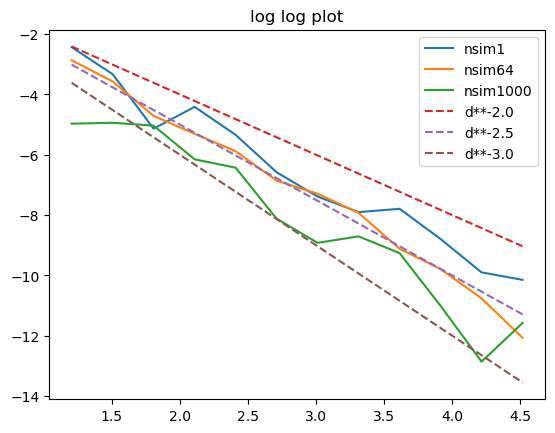

In [11]:
def nRRMC_llplt():
    T = 1.5 # this problem is unstable for T>3
    DTS = np.power(0.5,np.array(range(4,16)))
    Ns = [1,64,1000]
    for nsim in Ns:
        errors = np.array([(abs(nsol(T, d, nsim )-T**2))/(T**2) for d in DTS])
        plt.plot(-np.log(DTS)/np.log(10),np.log(errors)/np.log(10), label = f"nsim{nsim}")

    dgs = np.arange(2,3.5,0.5)
    for l in dgs:
        ref = np.array([pow(d,l) for d in DTS])
        plt.plot(-np.log(DTS)/np.log(10),np.log(ref)/np.log(10),label =f"d**-{l}",linestyle="dashed")
    plt.legend()
    plt.title("log log plot")
    plt.show()

nRRMC_llplt()

# TODO
- Quasi RRMC, we already have optimal order in $DT$ but not in $nsim$ in our examples we always had an aggressively high russian roulette rate. So we conjecture that coordinating the first russian roulette in the first inner recursion from each outer recursion is the most significant 
- example RRMC+coupling on boundary ODE problem (kind of difficult to implement)
- maybe other type of control variates for RRMC for an obvious high frequency term for example, what is boils down to is a type of extrapolation maybe we can take ideas from time series analysis
- maybe other type of russian roulette strategies, sampling techniques  or different outer recursion paths can make a difference?
- maybe error estimates from the MC corrections?
- maybe techniques to study error properties of these kind of methods numerically (like adding noise at certain parts of a certain magnitude)